### Importing libraries 

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Loading the dataset

In [132]:
simulated_cleaned_tx_df = pd.read_csv('../SavedData/dataset2_cleaned.csv')

In [133]:
simulated_cleaned_tx_df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
0,01/01/2023,00:00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00
1,01/01/2023,00:00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00
2,01/01/2023,00:00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00
3,01/01/2023,00:00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00
4,01/01/2023,00:00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00
...,...,...,...,...,...,...,...,...
229189,06/12/2023,20:54:00,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00
229190,06/12/2023,20:55:00,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00
229191,06/12/2023,21:05:00,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00
229192,06/12/2023,21:13:00,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00


### Splitting the data into training and testing 

In [134]:
copied_simulated_tx_df = simulated_cleaned_tx_df.copy()

# Splitting the copied dataset into historical_transactions and testing_transactions 
training_transactions, testing_transactions = train_test_split(copied_simulated_tx_df, test_size=0.2, random_state=12)

# Displaying the shapes to verify the split
training_transactions.shape, testing_transactions.shape


((183355, 8), (45839, 8))

In [135]:
testing_transactions.to_csv('../SavedData/dataset2_testing_transaction.csv', index=False)

In [136]:
training_transactions.to_csv('../SavedData/dataset2_training_transaction.csv',index=False)

### Splitting the training transactions into payments and expenditures

In [137]:
payments_training_df = training_transactions[training_transactions['Amount'] > 0]
expenditures_training_df = training_transactions[training_transactions['Amount'] < 0]

In [138]:
# Taking the absolute values of the amount column
expenditures_training_df["Amount"] = expenditures_training_df["Amount"].abs()

expenditures_training_df

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_2772/721076894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_training_df["Amount"] = expenditures_training_df["Amount"].abs()


,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
109964,25/06/2023,11:05:00,975345315.0,20105.404800,80.50,NaN,Topshop,2023-06-25 11:05:00
190427,17/10/2023,12:57:00,162370388.0,-2312.382900,43.42,NaN,Tesco,2023-10-17 12:57:00
81046,02/05/2023,19:18:00,145553416.0,-1516.558550,29.11,NaN,Tesco,2023-05-02 19:18:00
89182,22/05/2023,05:18:00,145387690.0,3671.032538,2.37,NaN,Sainsbury Local,2023-05-22 05:18:00
61119,31/03/2023,23:59:00,310171581.0,-651.334154,18.99,NaN,PureGym,2023-03-31 23:59:00
...,...,...,...,...,...,...,...,...
206083,05/11/2023,07:55:00,550169791.0,22875.430900,45.04,NaN,Etsy,2023-11-05 07:55:00
36482,23/02/2023,12:38:00,554792076.0,2248.810443,75.74,NaN,Topshop,2023-02-23 12:38:00
40177,01/03/2023,00:00:00,624563756.0,-14.727071,822.00,NaN,LBG,2023-03-01 00:00:00
150781,24/08/2023,20:15:00,176922958.0,1440.312330,37.43,NaN,Deliveroo,2023-08-24 20:15:00


## Creating an anomaly detection model using IQR for thresholds

### Threshold function

In [139]:
def calculate_thresholds(group, multiplier, percent_increment):
    quantiles = group['Amount'].quantile([0.25, 0.5, 0.75])
    IQR = quantiles[0.75] - quantiles[0.25]
    
    if IQR == 0:
        # When there's no variability, use the median and apply percent increment
        threshold = quantiles[0.5] * (1 + percent_increment)
    else:
        # Standard threshold calculation using IQR
        threshold = quantiles[0.75] + multiplier * IQR
    
    return threshold


### Creating anomaly detection dataframe: expenditures

In [140]:
# Ensure anomaly_detection_by_expenditures_df is indexed by 'Account No'
anomaly_detection_by_expenditures_df = expenditures_training_df[['Account No']].drop_duplicates().reset_index(drop=True)
anomaly_detection_by_expenditures_df.set_index('Account No', inplace=True)

# Assuming multipliers and percent_increments are defined as before
multipliers = [1.5, 3, 5]
percent_increments = [0.333, 0.666, 1]

# Define threshold columns
threshold_columns = ['Overall_Threshold_1_IQR', 'Overall_Threshold_2_IQR', 'Overall_Threshold_3_IQR']

# Initialising columns in anomaly_detection_by_expenditures_df to store threshold values
for col in threshold_columns:
    anomaly_detection_by_expenditures_df[col] = np.nan

# Calculate thresholds and update anomaly_detection_by_expenditures_df
for multiplier, percent_increment, col_name in zip(multipliers, percent_increments, threshold_columns):
    # Calculate thresholds for each Account No group
    thresholds = expenditures_training_df.groupby('Account No').apply(
        lambda group: calculate_thresholds(group, multiplier, percent_increment)
    ).reset_index(name=col_name)
    
    # Correctly index the thresholds DataFrame to facilitate direct mapping
    thresholds.set_index('Account No', inplace=True)
    
    # Map calculated thresholds to anomaly_detection_by_expenditures_df
    anomaly_detection_by_expenditures_df[col_name] = anomaly_detection_by_expenditures_df.index.map(
        thresholds[col_name]
    )

In [141]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_3']))).to_dict()

anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_1'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_2'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_3'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [142]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_3']))).to_dict()

anomaly_detection_by_expenditures_df['Business_Threshold_1'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_expenditures_df['Business_Threshold_2'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_expenditures_df['Business_Threshold_3'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [143]:
# Extracting keys from 'transfer_to_accounts_threshold_1_IQR' to create 'user_user_interaction'
anomaly_detection_by_expenditures_df['user_user_interaction'] = anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

# Extracting keys from 'industry_threshold_1_IQR' to create 'user_industry_interaction'
anomaly_detection_by_expenditures_df['user_business_interaction'] = anomaly_detection_by_expenditures_df['Business_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

anomaly_detection_by_expenditures_df


,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
975345315.0,190.38000,295.0200,434.5400,NaN,NaN,NaN,"{'Amazon': 23.39415, 'Blizzard': 19.98167, 'Bo...","{'Amazon': 29.255850000000002, 'Blizzard': 24....","{'Amazon': 35.1, 'Blizzard': 29.98, 'Boots': 1...",None,"[Amazon, Blizzard, Boots, Brilliant Brushes, C..."
162370388.0,325.70875,511.5400,759.3150,{574137161.0: 559.86},{574137161.0: 700.14},{574137161.0: 840.0},"{'Amazon': 10.65067, 'Fat Face': 151.962, 'LBG...","{'Amazon': 13.31933, 'Fat Face': 190.038, 'LBG...","{'Amazon': 15.98, 'Fat Face': 228.0, 'LBG': 25...",[574137161.0],"[Amazon, Fat Face, LBG, Loosely Fitted, Matala..."
145553416.0,89.40250,133.4500,192.1800,NaN,NaN,NaN,"{'Blizzard': 19.98167, 'Deliveroo': 36.4049999...","{'Blizzard': 24.98833, 'Deliveroo': 36.8924999...","{'Blizzard': 29.98, 'Deliveroo': 37.5424999999...",None,"[Blizzard, Deliveroo, Fat Face, JustEat, Mojan..."
145387690.0,101.70000,154.3350,224.5150,NaN,NaN,NaN,"{'AMAZON': 48.824999999999996, 'Amazon': 65.02...","{'AMAZON': 75.0, 'Amazon': 100.1, 'Blackwell's...","{'AMAZON': 109.9, 'Amazon': 146.87, 'Blackwell...",None,"[AMAZON, Amazon, Blackwell's, Blizzard, Boots,..."
310171581.0,84.62250,126.2775,181.8175,NaN,NaN,NaN,"{'Blizzard': 19.98167, 'Deliveroo': 33.25835, ...","{'Blizzard': 24.98833, 'Deliveroo': 41.59165, ...","{'Blizzard': 29.98, 'Deliveroo': 49.9, 'Etsy':...",None,"[Blizzard, Deliveroo, Etsy, Gamestation, JustE..."
...,...,...,...,...,...,...,...,...,...,...,...
331684336.0,1898.95500,3017.9100,4509.8500,{250957494.0: 1039.74},{250957494.0: 1300.26},{250957494.0: 1560.0},"{'Blackwell's': 33.83749999999999, 'Deliveroo'...","{'Blackwell's': 41.70499999999999, 'Deliveroo'...","{'Blackwell's': 52.194999999999986, 'Deliveroo...",[250957494.0],"[Blackwell's, Deliveroo, Halifax, JustEat, Sai..."
744211756.0,90.68375,137.3000,199.4550,NaN,NaN,NaN,"{'Amazon': 10.65067, 'Blizzard': 19.98167, 'Br...","{'Amazon': 13.31933, 'Blizzard': 24.98833, 'Br...","{'Amazon': 15.98, 'Blizzard': 29.98, 'Brillian...",None,"[Amazon, Blizzard, Brilliant Brushes, CeX, Del..."
426466211.0,236.88500,369.5450,546.4250,{311467864.0: 546.53},{311467864.0: 683.47},{311467864.0: 820.0},"{'Blackwell's': 39.93668, 'Blizzard': 19.98167...","{'Blackwell's': 49.94332, 'Blizzard': 24.98833...","{'Blackwell's': 59.92, 'Blizzard': 29.98, 'CeX...",[311467864.0],"[Blackwell's, Blizzard, CeX, Deliveroo, Gamest..."


### Creating anomaly detection dataframe: payments

In [144]:
# Ensure anomaly_detection_by_expenditures_df is indexed by 'Account No'
anomaly_detection_by_payments_df = payments_training_df[['Account No']].drop_duplicates().reset_index(drop=True)
anomaly_detection_by_payments_df.set_index('Account No', inplace=True)

# Assuming multipliers and percent_increments are defined as before
multipliers = [1.5, 3, 5]
percent_increments = [0.333, 0.666, 1]

# Define threshold columns
threshold_columns = ['Overall_Threshold_1_IQR', 'Overall_Threshold_2_IQR', 'Overall_Threshold_3_IQR']

# Initializing columns in anomaly_detection_by_expenditures_df to store threshold values
for col in threshold_columns:
    anomaly_detection_by_payments_df[col] = np.nan

# Calculate thresholds and update anomaly_detection_by_expenditures_df
for multiplier, percent_increment, col_name in zip(multipliers, percent_increments, threshold_columns):
    # Calculate thresholds for each Account No group
    thresholds = payments_training_df.groupby('Account No').apply(
        lambda group: calculate_thresholds(group, multiplier, percent_increment)
    ).reset_index(name=col_name)
    
    # Correctly index the thresholds DataFrame to facilitate direct mapping
    thresholds.set_index('Account No', inplace=True)
    
    # Map calculated thresholds to anomaly_detection_by_expenditures_df
    anomaly_detection_by_payments_df[col_name] = anomaly_detection_by_payments_df.index.map(
        thresholds[col_name]
    )
anomaly_detection_by_payments_df

,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR
Account No,,,
179173981.0,2432.725,3040.450,3650.0
624563756.0,2427.393,3033.786,3642.0
354894456.0,2258.102,2822.204,3388.0
815993333.0,1532.950,1915.900,2300.0
587225252.0,3800.000,5600.000,8000.0
...,...,...,...
198630866.0,1070.000,1475.000,2015.0
656389634.0,4585.520,5731.040,6880.0
715068825.0,3500.000,4250.000,5250.0


In [145]:
thresholds_1 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_3']))).to_dict()

anomaly_detection_by_payments_df['Third_Party_Account_Threshold_1'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_payments_df['Third_Party_Account_Threshold_2'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_payments_df['Third_Party_Account_Threshold_3'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [146]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_3']))).to_dict()

anomaly_detection_by_payments_df['Business_Threshold_1'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_payments_df['Business_Threshold_2'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_payments_df['Business_Threshold_3'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))


In [147]:
# Extracting keys from 'transfer_to_accounts_threshold_1_IQR' to create 'user_user_interaction'
anomaly_detection_by_payments_df['user_user_interaction'] = anomaly_detection_by_payments_df['Third_Party_Account_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

# Extracting keys from 'industry_threshold_1_IQR' to create 'user_industry_interaction'
anomaly_detection_by_payments_df['user_business_interaction'] = anomaly_detection_by_payments_df['Business_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)


In [148]:
anomaly_detection_by_payments_df

,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
179173981.0,2432.725,3040.450,3650.0,NaN,NaN,NaN,{'Matalan': 2432.725},{'Matalan': 3042.275},{'Matalan': 3650.0},None,[Matalan]
624563756.0,2427.393,3033.786,3642.0,NaN,NaN,NaN,{'CPA': 2427.393},{'CPA': 3035.607},{'CPA': 3642.0},None,[CPA]
354894456.0,2258.102,2822.204,3388.0,NaN,NaN,NaN,{'Happy Days Home': 2258.102},{'Happy Days Home': 2823.898},{'Happy Days Home': 3388.0},None,[Happy Days Home]
815993333.0,1532.950,1915.900,2300.0,{992204045.0: 1532.95},{992204045.0: 1917.05},{992204045.0: 2300.0},NaN,NaN,NaN,[992204045.0],None
587225252.0,3800.000,5600.000,8000.0,{425964226.0: 1066.3999999999999},{425964226.0: 1333.6000000000001},{425964226.0: 1600.0},{'Matalan': 2666.0},{'Matalan': 3334.0},{'Matalan': 4000.0},[425964226.0],[Matalan]
...,...,...,...,...,...,...,...,...,...,...,...
198630866.0,1070.000,1475.000,2015.0,{919185264.0: 1070.0},{919185264.0: 1475.0},{919185264.0: 2015.0},NaN,NaN,NaN,[919185264.0],None
656389634.0,4585.520,5731.040,6880.0,{449871732.0: 4585.5199999999995},{449871732.0: 5734.4800000000005},{449871732.0: 6880.0},NaN,NaN,NaN,[449871732.0],None
715068825.0,3500.000,4250.000,5250.0,{199016328.0: 3500.0},{199016328.0: 4250.0},{199016328.0: 5250.0},NaN,NaN,NaN,[199016328.0],None


## Risk flagging function- per user transaction

In [149]:
def get_threshold_value(user_data, key, identifier=None):
    """
    Retrieves threshold values for different risk levels from the user's data.
    If the threshold value for a specific key is a dictionary, it returns the threshold
    for the specified identifier. If no identifier-specific threshold is found,
    it returns a high default threshold.
    """
    value = user_data.get(key, 0)
    return value if not isinstance(value, dict) else value.get(identifier, float('inf'))

def assess_transaction_risk(account_no, amount, third_party_account_no, third_party_name, anomaly_detection_by_expenditures_df, anomaly_detection_by_payments_df):
    if amount >= 0:
        anomaly_detection_df = anomaly_detection_by_payments_df
    else:
        anomaly_detection_df = anomaly_detection_by_expenditures_df

    amount = abs(amount)  # Convert amount to absolute for uniform comparison
    # Safely fetch user data; default to an empty dict if the account_no is not found
    user_data = anomaly_detection_df.loc[account_no].to_dict() if account_no in anomaly_detection_df.index else {}

    # Initialize interaction lists safely
    user_user_interaction = user_data.get('user_user_interaction', []) or []
    user_business_interaction = user_data.get('user_business_interaction', []) or []

    risk_level = "No Risk"

    # Check for third-party account interactions
    if third_party_account_no and third_party_account_no in user_user_interaction:
        thresholds = [
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_1', third_party_account_no),
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_2', third_party_account_no),
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_3', third_party_account_no)
        ]
    # Check for business interactions
    elif third_party_name and third_party_name in user_business_interaction:
        thresholds = [
            get_threshold_value(user_data, 'Business_Threshold_1', third_party_name),
            get_threshold_value(user_data, 'Business_Threshold_2', third_party_name),
            get_threshold_value(user_data, 'Business_Threshold_3', third_party_name)
        ]
    else:
        # Default to overall thresholds if specific ones aren't found or applicable
        thresholds = [
            user_data.get('Overall_Threshold_1_IQR', float('inf')),
            user_data.get('Overall_Threshold_2_IQR', float('inf')),
            user_data.get('Overall_Threshold_3_IQR', float('inf'))
        ]
    # Determine the risk level based on thresholds
    if amount > thresholds[2]:
        risk_level = "High Risk"
    elif amount > thresholds[1]:
        risk_level = "Medium Risk"
    elif amount > thresholds[0]:
        risk_level = "Low Risk"

    # Adjust the risk level based on absolute amount thresholds
    if amount <= 15:
        risk_level = "No Risk"
    elif amount <= 50:
        risk_level = "Low Risk" if risk_level != "No Risk" else "No Risk"
    elif amount <= 100:
        risk_level = "Medium Risk" if risk_level == "High Risk" else risk_level

    return risk_level


In [224]:
testing_transactions['risk_level'] = [
    assess_transaction_risk(
        row['Account No'], row['Amount'], row.get('Third Party Account No'), row.get('Third Party Name'),
        anomaly_detection_by_expenditures_df, anomaly_detection_by_payments_df
    ) for _, row in testing_transactions.iterrows()
]


testing_transactions.shape

(45839, 10)

In [225]:
risk_level_counts = testing_transactions['risk_level'].value_counts()
print(risk_level_counts)


No Risk        43727
Low Risk        1445
Medium Risk      449
High Risk        218
Name: risk_level, dtype: int64


In [226]:
# Define the mapping dictionary
risk_level_map = {
    'No Risk': 0,
    'Low Risk': 0.33,
    'Medium Risk': 0.66,
    'High Risk': 1
}

testing_transactions['risk_level_numeric'] = testing_transactions['risk_level'].map(risk_level_map)

testing_transactions[testing_transactions['risk_level_numeric']== 0.33]

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
141449,06/08/2023,03:33:00,496395938.0,11089.827658,-88.40,NaN,Loosely Fitted,2023-08-06 03:33:00,Low Risk,0.33
128615,22/07/2023,11:02:00,147474476.0,3781.733037,-105.73,NaN,Revella,2023-07-22 11:02:00,Low Risk,0.33
175960,30/09/2023,10:48:00,930277104.0,11141.312949,-235.20,NaN,Fat Face,2023-09-30 10:48:00,Low Risk,0.33
145302,13/08/2023,12:17:00,541639148.0,4904.981751,-130.89,NaN,Fat Face,2023-08-13 12:17:00,Low Risk,0.33
124005,12/07/2023,06:01:00,128033695.0,4233.570223,-25.98,NaN,Sainsbury Local,2023-07-12 06:01:00,Low Risk,0.33
...,...,...,...,...,...,...,...,...,...,...
48634,10/03/2023,17:14:00,657528784.0,-689.588100,-312.20,NaN,Loosely Fitted,2023-03-10 17:14:00,Low Risk,0.33
84134,09/05/2023,16:18:00,478412511.0,1379.999324,-34.95,NaN,The Works,2023-05-09 16:18:00,Low Risk,0.33
19526,29/01/2023,13:21:00,285115279.0,-28.160330,-152.60,NaN,Topshop,2023-01-29 13:21:00,Low Risk,0.33
184191,06/10/2023,05:17:00,187111705.0,6865.321633,-38.92,NaN,Amazon,2023-10-06 05:17:00,Low Risk,0.33


In [227]:
no_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'No Risk']

low_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'Low Risk']

medium_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'Medium Risk']

high_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'High Risk']


In [228]:
testing_transactions_expenditures= testing_transactions[testing_transactions['Amount']< 0]
testing_transactions_expenditures["Amount"] = testing_transactions_expenditures["Amount"].abs()
testing_transactions_expenditures.shape

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_2772/1112521018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_transactions_expenditures["Amount"] = testing_transactions_expenditures["Amount"].abs()


(43713, 10)

In [229]:
testing_transactions_expenditures.to_csv('testing_transactions_expenditures.csv')

In [230]:
no_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'No Risk']

low_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'Low Risk']

medium_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'Medium Risk']

high_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'High Risk']


In [231]:
testing_transactions_payments= testing_transactions[testing_transactions['Amount']> 0]
testing_transactions_payments.shape

(2125, 10)

In [232]:
no_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'No Risk']

low_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'Low Risk']

medium_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'Medium Risk']

high_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'High Risk']


In [233]:
low_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
141449,06/08/2023,03:33:00,496395938.0,11089.827658,-88.40,NaN,Loosely Fitted,2023-08-06 03:33:00,Low Risk,0.33
128615,22/07/2023,11:02:00,147474476.0,3781.733037,-105.73,NaN,Revella,2023-07-22 11:02:00,Low Risk,0.33
175960,30/09/2023,10:48:00,930277104.0,11141.312949,-235.20,NaN,Fat Face,2023-09-30 10:48:00,Low Risk,0.33
145302,13/08/2023,12:17:00,541639148.0,4904.981751,-130.89,NaN,Fat Face,2023-08-13 12:17:00,Low Risk,0.33
124005,12/07/2023,06:01:00,128033695.0,4233.570223,-25.98,NaN,Sainsbury Local,2023-07-12 06:01:00,Low Risk,0.33
...,...,...,...,...,...,...,...,...,...,...
48634,10/03/2023,17:14:00,657528784.0,-689.588100,-312.20,NaN,Loosely Fitted,2023-03-10 17:14:00,Low Risk,0.33
84134,09/05/2023,16:18:00,478412511.0,1379.999324,-34.95,NaN,The Works,2023-05-09 16:18:00,Low Risk,0.33
19526,29/01/2023,13:21:00,285115279.0,-28.160330,-152.60,NaN,Topshop,2023-01-29 13:21:00,Low Risk,0.33
184191,06/10/2023,05:17:00,187111705.0,6865.321633,-38.92,NaN,Amazon,2023-10-06 05:17:00,Low Risk,0.33


In [234]:
medium_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
14645,18/01/2023,17:22:00,643610517.0,-219.303691,-136.49,NaN,Fat Face,2023-01-18 17:22:00,Medium Risk,0.66
106536,17/06/2023,13:29:00,303843160.0,968.263000,-208.60,NaN,Topshop,2023-06-17 13:29:00,Medium Risk,0.66
186321,09/10/2023,18:10:00,897592348.0,14606.655986,-221.20,NaN,Matalan,2023-10-09 18:10:00,Medium Risk,0.66
72788,26/04/2023,18:43:00,901432314.0,2628.057097,-99.97,NaN,Hobby Lobby,2023-04-26 18:43:00,Medium Risk,0.66
176306,30/09/2023,18:26:00,316793091.0,1641.014310,-51.49,NaN,Hobby Lobby,2023-09-30 18:26:00,Medium Risk,0.66
...,...,...,...,...,...,...,...,...,...,...
64103,04/04/2023,17:57:00,291580432.0,79.391500,-143.99,NaN,Topshop,2023-04-04 17:57:00,Medium Risk,0.66
14156,17/01/2023,13:48:00,532525712.0,350.958700,-79.98,NaN,Gamestation,2023-01-17 13:48:00,Medium Risk,0.66
11869,13/01/2023,09:45:00,158766229.0,1587.929551,-86.97,NaN,Brilliant Brushes,2023-01-13 09:45:00,Medium Risk,0.66
7703,05/01/2023,12:39:00,895331556.0,675.130000,-99.98,NaN,Gamestation,2023-01-05 12:39:00,Medium Risk,0.66


In [235]:
high_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
107134,18/06/2023,16:11:00,383345285.0,363.732176,-112.98,NaN,Sports Direct,2023-06-18 16:11:00,High Risk,1.0
98684,01/06/2023,10:20:00,627936697.0,1140.717600,-193.50,NaN,Topshop,2023-06-01 10:20:00,High Risk,1.0
17541,24/01/2023,19:54:00,994214354.0,980.830000,-1870.00,534204159.0,NaN,2023-01-24 19:54:00,High Risk,1.0
33711,16/02/2023,09:31:00,950234174.0,815.028676,-150.12,NaN,Gamestation,2023-02-16 09:31:00,High Risk,1.0
28469,04/02/2023,17:11:00,478651121.0,648.543830,-197.00,NaN,Matalan,2023-02-04 17:11:00,High Risk,1.0
...,...,...,...,...,...,...,...,...,...,...
188949,14/10/2023,17:56:00,373875019.0,15831.854013,-258.30,NaN,Fitted Stitch,2023-10-14 17:56:00,High Risk,1.0
144233,11/08/2023,14:04:00,601627384.0,4720.955092,-187.01,NaN,JD Sports,2023-08-11 14:04:00,High Risk,1.0
211303,14/11/2023,10:53:00,652048867.0,-1.449100,-500.00,512989907.0,NaN,2023-11-14 10:53:00,High Risk,1.0
182093,02/10/2023,10:08:00,391688371.0,496.282300,-1470.00,534097839.0,NaN,2023-10-02 10:08:00,High Risk,1.0


### Plotting results

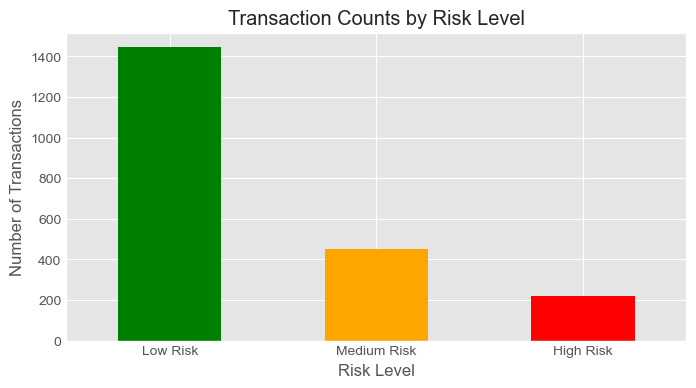

In [250]:
# Prepare risk level counts
risk_level_counts = pd.Series({
    "Low Risk": low_risk_transactions.shape[0],
    "Medium Risk": medium_risk_transactions.shape[0],
    "High Risk": high_risk_transactions.shape[0],
})


# Plotting
plt.style.use('ggplot')  # Using a nicer style
fig, ax = plt.subplots(figsize=(8, 4))
risk_level_counts.plot(kind='bar', color=['green', 'orange', 'red'], ax=ax)
ax.set_title('Transaction Counts by Risk Level')
ax.set_xlabel('Risk Level')
ax.set_ylabel('Number of Transactions')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()


In [257]:
total_testing_set = testing_transactions.shape[0]
total_testing_set

45839

This is out of the testing set of 45839. 
No Risk= 43727 --> 95.39%
Low Risk= 1445 --> 3.15%
Medium Risk= 449 --> 
High Risk= 218

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_2772/868544885.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


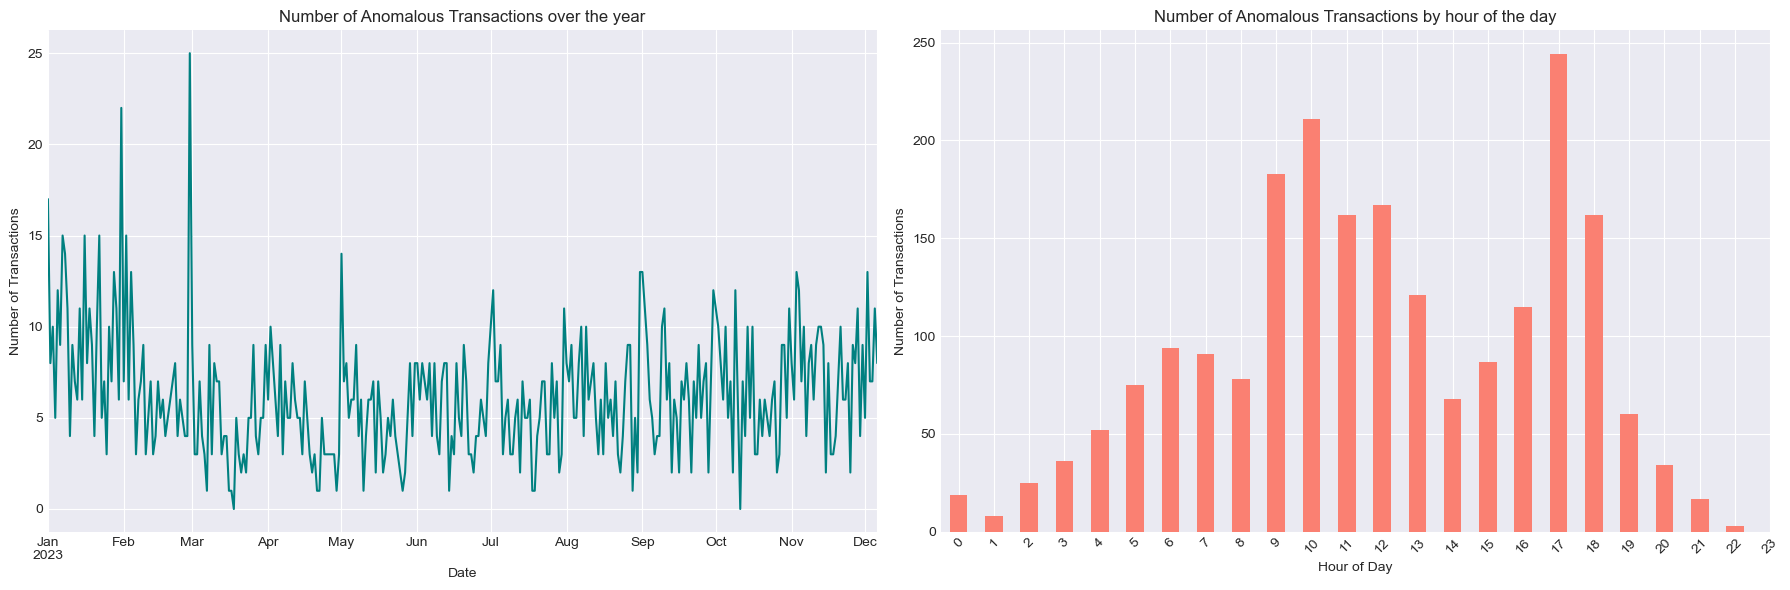

In [243]:
# Resample by day and count transactions
daily_transactions = all_transactions.resample('D').size()

# Extract hour from the index and count transactions per hour
hourly_transactions = all_transactions.groupby(all_transactions.index.hour).size()

# Using a style for better aesthetics
plt.style.use('seaborn-darkgrid')

# Setup subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot daily transactions
daily_transactions.plot(ax=ax1, title='Number of Anomalous Transactions over the year', color='teal')
ax1.set_ylabel('Number of Transactions')
ax1.set_xlabel('Date')

# Plot hourly transactions
hourly_transactions.plot(ax=ax2, kind='bar', title='Number of Anomalous Transactions by hour of the day', color='salmon')
ax2.set_ylabel('Number of Transactions')
ax2.set_xlabel('Hour of Day')
ax2.set_xticks(range(0, 24))
ax2.set_xticklabels(range(0, 24), rotation=45)

# Show the plots side by side
plt.tight_layout()
plt.show()


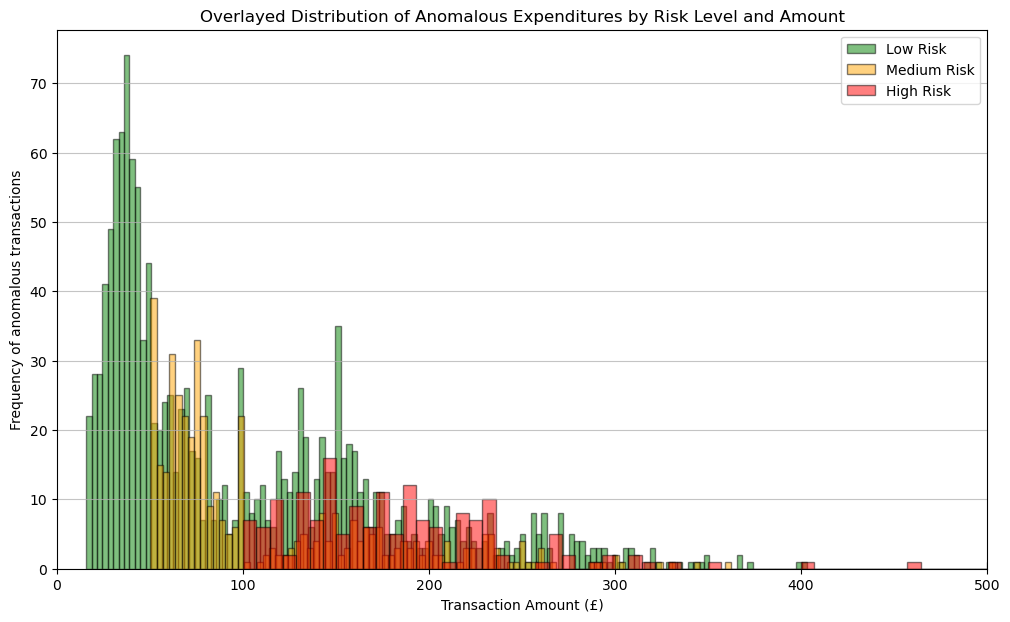

In [221]:
plt.figure(figsize=(12, 7))  # Set the figure size

# Histogram for Low Risk Transactions
plt.hist(low_risk_expenditures['Amount'], bins=1000, color='green', edgecolor='black', alpha=0.5, label='Low Risk')

# Histogram for Medium Risk Transactions
plt.hist(medium_risk_expenditures['Amount'], bins=1000, color='orange', edgecolor='black', alpha=0.5, label='Medium Risk')

# Histogram for High Risk Transactions
plt.hist(high_risk_expenditures['Amount'], bins=1700, color='red', edgecolor='black', alpha=0.5, label='High Risk')

# Titles and labels
plt.title('Overlayed Distribution of Anomalous Expenditures by Risk Level and Amount')
plt.xlabel('Transaction Amount (£)')
plt.ylabel('Frequency of anomalous transactions')
plt.xlim(0, 500)  # Assuming you want to keep the same x-axis limit as before
plt.grid(axis='y', alpha=0.75)

# Legend
plt.legend(loc='upper right')

# Show the plot
plt.show()


Setting the limit in the above graph to 500

In [191]:
import datetime
given_date = expenditures_training_df['Datetime'][0]
formated_date = datetime.datetime.strptime(given_date,"%m/%d/%Y, %H:%M:%S")
Unix_timestamp = datetime.datetime.timestamp(formated_date)
print("The Unix timestamp for the given input date is:")
print(Unix_timestamp)

KeyError: 0

In [ ]:
def unix_ts_convert(date):
    given_date = date
    formated_date = datetime.datetime.strptime(given_date,"%Y-%m-%d %H:%M:%S")
    Unix_timestamp = datetime.datetime.timestamp(formated_date)
    return int(Unix_timestamp)

In [ ]:
iso_forest_tx = simulated_cleaned_tx_df.reset_index()
iso_forest_tx['Unix Timestamp'] = iso_forest_tx['Datetime'].apply(unix_ts_convert)

In [ ]:
Account_Nos = list(iso_forest_tx['Account No'].unique())

In [ ]:
Account_Nos

In [ ]:
iso_forest_user_groups = iso_forest_tx.groupby('Account No')

In [ ]:
iso_forest_user_groups.apply(lambda x: x)

In [ ]:
given_date['Datetime']

biz_tx_count = biz_tx_df.groupby('to_randomly_generated_account')['monopoly_money_amount'].count()

In [216]:
testing_transactions_expenditures['Unix Timestamp'] = testing_transactions_expenditures['Datetime'].apply(unix_ts_convert)

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_2772/751573844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_transactions_expenditures['Unix Timestamp'] = testing_transactions_expenditures['Datetime'].apply(unix_ts_convert)


In [217]:
testing_transactions_expenditures

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric,Unix Timestamp
50365,14/03/2023,18:33:00,712474734.0,-1324.548831,31.23,NaN,Deliveroo,2023-03-14 18:33:00,No Risk,0.0,1678818780
50317,14/03/2023,17:28:00,419550103.0,6544.593463,125.30,NaN,Loosely Fitted,2023-03-14 17:28:00,No Risk,0.0,1678814880
156768,31/08/2023,23:59:00,834581602.0,925.931550,7.00,NaN,Xbox,2023-08-31 23:59:00,No Risk,0.0,1693522740
198076,31/10/2023,09:27:00,250957494.0,1090.427100,37.99,NaN,Sports Direct,2023-10-31 09:27:00,No Risk,0.0,1698744420
46751,05/03/2023,16:34:00,675231808.0,4038.532728,158.90,NaN,Selfridges,2023-03-05 16:34:00,No Risk,0.0,1678034040
...,...,...,...,...,...,...,...,...,...,...,...
177952,30/09/2023,23:59:00,887156614.0,-838.824821,5.99,NaN,Mojang Studios,2023-09-30 23:59:00,No Risk,0.0,1696114740
138380,31/07/2023,23:59:00,117308635.0,1863.971883,14.99,NaN,Blizzard,2023-07-31 23:59:00,No Risk,0.0,1690844340
27201,02/02/2023,14:46:00,299871610.0,-1106.116847,55.29,NaN,Topshop,2023-02-02 14:46:00,No Risk,0.0,1675349160
11255,11/01/2023,19:39:00,656812046.0,2980.102487,118.16,NaN,Tesco,2023-01-11 19:39:00,No Risk,0.0,1673465940


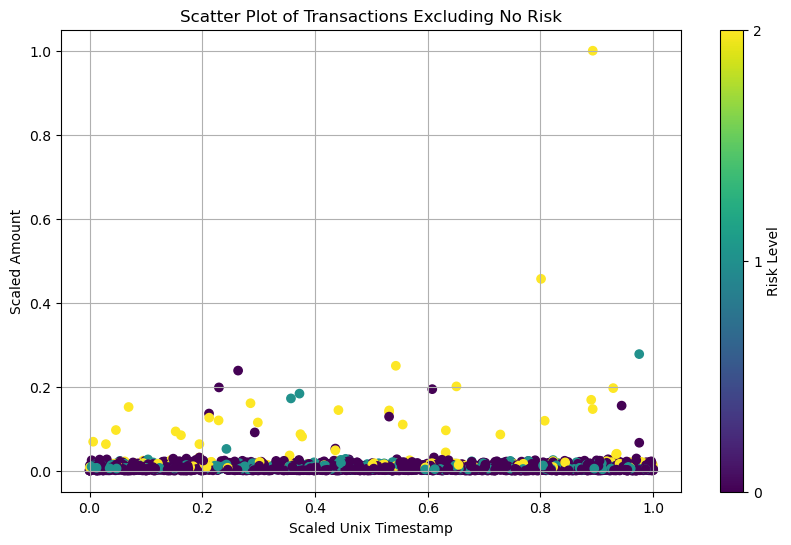

In [220]:
from sklearn.preprocessing import MinMaxScaler

# Filter out transactions with 'No Risk'
filtered_testing_transactions_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] != 'No Risk']

# Initialise scaler
scaler = MinMaxScaler()

# Scale the 'Amount' and 'Unix Timestamp' columns
testing_transactions_expenditures_scaled = filtered_testing_transactions_expenditures.copy()
testing_transactions_expenditures_scaled[['Amount', 'Unix Timestamp']] = scaler.fit_transform(filtered_testing_transactions_expenditures[['Amount', 'Unix Timestamp']])

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(testing_transactions_expenditures_scaled['Unix Timestamp'], testing_transactions_expenditures_scaled['Amount'],
                      c=pd.factorize(testing_transactions_expenditures_scaled['risk_level'])[0], cmap='viridis')
plt.colorbar(scatter, ticks=np.arange(len(np.unique(testing_transactions_expenditures_scaled['risk_level']))), label='Risk Level')
plt.xlabel('Scaled Unix Timestamp')
plt.ylabel('Scaled Amount')
plt.title('Scatter Plot of Transactions Excluding No Risk')
plt.grid(True)
plt.show()

